In [84]:
import torch
import slangpy

N = 4
c = 2 
# m = slangpy.loadModule('bezier_compute.slang', defines={"NUM_CTRL_PTS": N, "DIM":c})
m = slangpy.loadModule('bezier.slang', defines={"NUM_CTRL_PTS": N, "DIM":c})
num_pts = 1000
t = torch.linspace(0.0, 1, num_pts, dtype=torch.float).cuda()
# control_pts = torch.tensor([[0.0,0.0],
#                             [1, 0],
#                             [1, 1],
#                             [0,1]], dtype=torch.float).cuda()

control_pts = 1*torch.rand((N,2),dtype=torch.float).cuda()
control_pts[-1] = control_pts[0]
output = torch.zeros((num_pts,2), dtype=torch.float).cuda()

# Number of threads launched = blockSize * gridSize
m.bezier2D(t=t, control_pts=control_pts, output=output).launchRaw(blockSize=(32, 1, 1), gridSize=(64, 1, 1))

gt_control_pts = torch.tensor([[0.0, 0.0],
                               [0.0, 1.0], 
                               [1.0, 1.0], 
                               [1.0, 0.0]]).cuda()
coeffs = torch.zeros((N,2), dtype=torch.float).cuda()
m.compute_coeffs(control_pts=control_pts, output=coeffs).launchRaw(blockSize=(4, 1, 1), gridSize=(1, 1, 1))

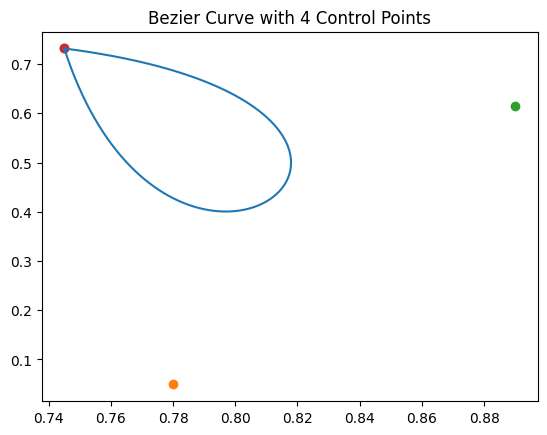

In [85]:
import matplotlib.pyplot as plt 

def curve_from_coeffs(t, coeffs):
    """ To check if coefficients are correct """
    output = torch.zeros(t.shape[0], coeffs.shape[1]).cuda()
    for i in range(coeffs.shape[0]):
        output = output + (t**i).view(-1,1) * coeffs[i].view(1,-1)
    return output 

curve_coeffs = curve_from_coeffs(t, coeffs)

plt.figure()
plt.plot(curve_coeffs[:,0].detach().cpu().numpy(), curve_coeffs[:,1].detach().cpu().numpy())
for i in range(control_pts.shape[0]):
    plt.scatter(control_pts[i][0].cpu(), control_pts[i][1].cpu())

plt.title(f'Bezier Curve with {N} Control Points')
plt.savefig(f'Bcurve_{N}_closed.png')

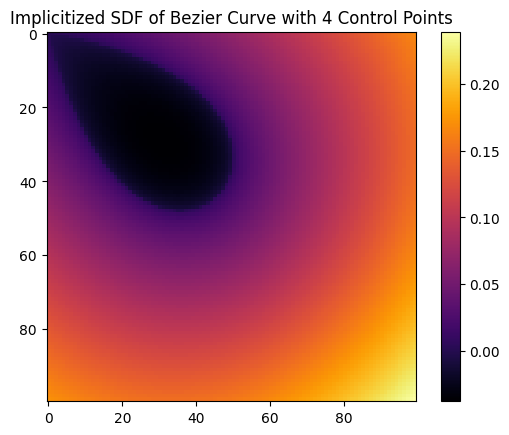

In [89]:
import matplotlib.pyplot as plt

## Computing SDF for line function 
num_points = 100 # for example, 100 points along each axis

# Generate evenly spaced points between 0 and 1
# Generate evenly spaced points between 0 and 1
xmin, xmax = torch.min(control_pts[:,0]), torch.max(control_pts[:,0])
ymin, ymax = torch.min(control_pts[:,1]), torch.max(control_pts[:,1])
px = torch.linspace(xmin, xmax, num_points)
py = torch.linspace(ymin, ymax, num_points)

# Create the meshgrid
x, y = torch.meshgrid(px, py.flip(dims=[0]), indexing='ij')  # 'i
xy = torch.stack([x,y], dim=-1 ).view(-1,2).cuda()
sdf_mats = torch.zeros(xy.shape[0], c*(N-1), c*(N-1)).cuda()

# m.bezier2DSDFtest(xy=xy, control_pts=control_pts, output=sdf).launchRaw(blockSize=(1024, 1, 1), gridSize=(1024, 1, 1))
m.bezier2DSDF(xy=xy, control_pts=control_pts, output=sdf_mats).launchRaw(blockSize=(256, 1, 1), gridSize=(64, 1, 1))
sdf = torch.linalg.det(sdf_mats)
sdf = torch.sgn(sdf) * torch.sqrt(torch.abs(sdf))


sdf_plot = sdf.view(num_points, num_points).cpu().numpy()

plt.imshow(sdf_plot.T, cmap='inferno')
plt.title(f'Implicitized SDF of Bezier Curve with {N} Control Points')
# plt.axis('off')
plt.colorbar()

plt.savefig(f'Bcurve_{N}_SDF_closed.png')


Text(0.5, 1.0, 'Bezier Curve with 2 Control Points (a line)')

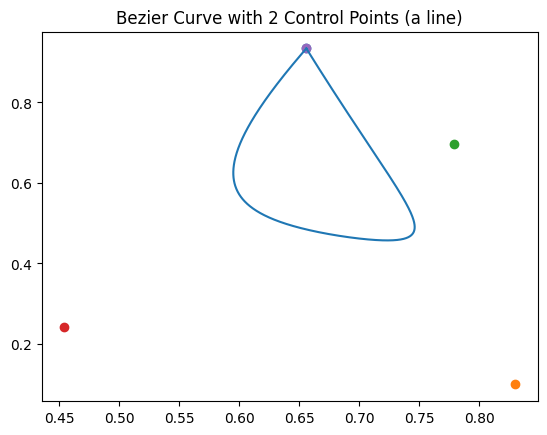

In [424]:
import matplotlib.pyplot as plt 

plt.figure()
plt.plot(output[:,0].detach().cpu().numpy(), output[:,1].detach().cpu().numpy())
for i in range(control_pts.shape[0]):
    plt.scatter(control_pts[i][0].cpu(), control_pts[i][1].cpu())

plt.title(f'Bezier Curve with {N} Control Points')